# Hello, Numerai

Hello and welcome to the Numerai Data Science Tournament!

This notebook is designed to help you build your first machine learning model and start competing the tournament.

In this notebook we will
1. Download and explore the Numerai dataset
2. Train and evaluate your first machine learning model
3. Deploy your model to start making live submissions

In [1]:
# Install dependencies
!pip install -q numerapi pandas pyarrow matplotlib lightgbm scikit-learn cloudpickle scipy==1.10.1

# Inline plots
%matplotlib inline

## 1. Dataset  

At a high level, the Numerai dataset is a tabular dataset that describes the stock market over time. It is compiled from high-quality (and expensive) data that might be difficult for individuals to obtain.

The unique thing about Numerai's dataset is that it is `obfuscated`, which means that the underlying stock ids, feature names, and target definitions are anonymized. This makes it so that we can give this data out for free and so that it can be modeled without any financial domain knowledge (or bias!).

### Listing the datasets
Firstly, take a look at the files Numerai offers below:

In [2]:
# Initialize NumerAPI - the official Python API client for Numerai
from numerapi import NumerAPI
napi = NumerAPI()

# list the datasets and available versions
all_datasets = napi.list_datasets()
dataset_versions = list(set(d.split('/')[0] for d in all_datasets))
print("Available versions:\n", dataset_versions)

# Set data version to one of the latest datasets
DATA_VERSION = "v4.3"

# Print all files available for download for our version
current_version_files = [f for f in all_datasets if f.startswith(DATA_VERSION)]
print("availbable", DATA_VERSION, "files:\n", current_version_files)

Available versions:
 ['v4.2', 'v4', 'v4.1', 'v4.3']
availbable v4.3 files:
 ['v4.3/features.json', 'v4.3/live_benchmark_models.parquet', 'v4.3/live_example_preds.csv', 'v4.3/live_example_preds.parquet', 'v4.3/live_int8.parquet', 'v4.3/meta_model.parquet', 'v4.3/train_benchmark_models.parquet', 'v4.3/train_int8.parquet', 'v4.3/validation_benchmark_models.parquet', 'v4.3/validation_example_preds.csv', 'v4.3/validation_example_preds.parquet', 'v4.3/validation_int8.parquet']


### Downloading datasets

The `features.json` file contains metadata about features in the dataset including:
- statistics on each feature
- helpful sets of features
- the targets available for training

Let's download it and take a look:

In [3]:
import json

# download the feature metadata file
napi.download_dataset(f"{DATA_VERSION}/features.json");

# read the metadata and display
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))
for metadata in feature_metadata:
  print(metadata, len(feature_metadata[metadata]))

2024-03-15 22:29:57,892 INFO numerapi.utils: target file already exists
2024-03-15 22:29:57,894 INFO numerapi.utils: download complete


feature_stats 2376
feature_sets 17
targets 41


### Feature Sets & Groups
As you can see there are many features and targets to choose from.

Instead of training a model on all 2000+ features, let's pick a subset of features to analyze.

Here are a few starter sets Numerai offers:

- `small` contains a minimal subset of features that have the highest [feature importance](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

- `medium` contains all the "basic" features, each unique in some way (e.g. P/E ratios vs analyst ratings)

- `all` contains all features in `medium` and their variants (e.g. P/E by country vs P/E by sector)

Let's take a look at the medium feature set:

In [4]:
feature_sets = feature_metadata["feature_sets"]
for feature_set in ["small", "medium", "all"]:
  print(feature_set, len(feature_sets[feature_set]))

small 42
medium 705
all 2376


In [5]:
print(feature_metadata.keys())
print(feature_metadata['feature_stats'])
print(feature_metadata['feature_sets'])
print(feature_metadata['targets'])


dict_keys(['feature_stats', 'feature_sets', 'targets'])
{'feature_honoured_observational_balaamite': {'legacy_uniqueness': nan, 'spearman_corr_w_target_nomi_20_mean': -0.0008683258726933546, 'spearman_corr_w_target_nomi_20_sharpe': -0.08497302517948851, 'spearman_corr_w_target_nomi_20_reversals': 7.04618724549861e-05, 'spearman_corr_w_target_nomi_20_autocorr': 0.032672629137608836, 'spearman_corr_w_target_nomi_20_arl': 3.92018779342723}, 'feature_polaroid_vadose_quinze': {'legacy_uniqueness': nan, 'spearman_corr_w_target_nomi_20_mean': 0.00016230089241112643, 'spearman_corr_w_target_nomi_20_sharpe': 0.016115632380543407, 'spearman_corr_w_target_nomi_20_reversals': 8.111279552770912e-05, 'spearman_corr_w_target_nomi_20_autocorr': -0.012822758725293527, 'spearman_corr_w_target_nomi_20_arl': 3.5531914893617023}, 'feature_untidy_withdrawn_bargeman': {'legacy_uniqueness': nan, 'spearman_corr_w_target_nomi_20_mean': -0.0007706626550766353, 'spearman_corr_w_target_nomi_20_sharpe': -0.08754831


The `medium` set seems much more reasonable.

Using it will speed up model training and reduce memory usage (required for Colab free tier).

Let's load the training data for just the medium feature set:

In [6]:
import pandas as pd

# Define our feature set
feature_set = feature_sets["medium"]

# Download the training data - this will take a few minutes
napi.download_dataset(f"{DATA_VERSION}/train_int8.parquet");

# Load only the "medium" feature set to
# Use the "all" feature set to use all features
train = pd.read_parquet(
    f"{DATA_VERSION}/train_int8.parquet",
    columns=["era", "target"] + feature_set
)

# Downsample to every 4th era to reduce memory usage and speedup model training (suggested for Colab free tier)
# Comment out the line below to use all the data
# train = train[train["era"].isin(train["era"].unique()[::4])]

2024-03-15 22:29:58,928 INFO numerapi.utils: target file already exists
2024-03-15 22:29:58,930 INFO numerapi.utils: download complete



### Training data

Each row represents a stock at a specific point in time:
- `id` is the stock id
- `era` is the date
- `target` is a measure of future returns for that stock
- `features` describe the attributes of the stock (eg. P/E ratio) for that date

In [7]:
train

,era,target,feature_abating_unadaptable_weakfish,feature_ablest_mauritanian_elding,feature_acclimatisable_unfeigned_maghreb,feature_accommodable_crinite_cleft,feature_accretive_sorrier_skedaddle,feature_acetose_periotic_coronation,feature_adam_incantational_winemaker,feature_additive_untrustworthy_hierologist,...,feature_witchy_orange_muley,feature_wombed_liberatory_malva,feature_won_stalwart_eisenstein,feature_wrathful_prolix_colotomy,feature_wrinkliest_unmaintainable_usk,feature_wrought_muckier_temporality,feature_yauld_antediluvial_subprefecture,feature_yelled_hysteretic_eath,feature_yoruban_unapplied_tawse,feature_zygodactyl_exponible_lathi
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0001,0.25,0,4,0,4,2,0,2,1,...,0,0,2,4,2,4,3,2,2,3
n003bee128c2fcfc,0001,0.75,4,2,2,2,2,3,2,1,...,3,3,2,0,2,2,1,3,2,1
n0048ac83aff7194,0001,0.25,4,4,2,0,2,0,2,4,...,0,1,2,0,2,3,2,1,2,2
n00691bec80d3e02,0001,0.75,1,4,1,1,2,0,2,2,...,2,1,2,2,2,3,2,2,2,2
n00b8720a2fdc4f2,0001,0.50,0,2,0,0,2,0,2,3,...,1,1,2,0,2,0,1,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffcc1dbdf2212e6,0574,0.75,0,2,1,1,4,2,0,4,...,4,2,4,3,4,4,4,4,3,0
nffd71b7f6a128df,0574,0.25,4,3,0,0,0,0,2,0,...,0,0,0,0,4,0,2,1,4,0
nffde3b371d67394,0574,0.25,1,2,1,2,3,2,4,2,...,3,2,1,2,2,0,3,4,3,0


### Eras
As mentioned above, each `era` corresponds to a different date. Each era is exactly 1 week apart.

It is helpful to think about rows of stocks within the same `era` as a single example. You will notice that throughout this notebook and other examples, we often talk about things "per era". For example, the number of rows per era represents the number of stocks in Numerai's investable universe on that date.

<Axes: title={'center': 'Number of rows per era'}, xlabel='Era'>

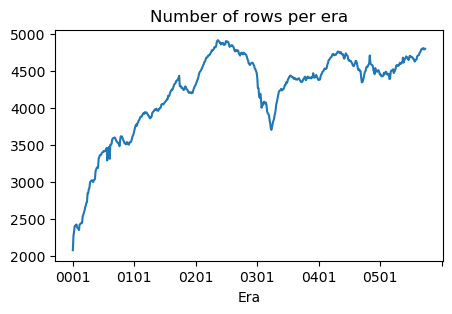

In [8]:
# Plot the number of rows per era
train.groupby("era").size().plot(
    title="Number of rows per era",
    figsize=(5, 3),
    xlabel="Era"
)

### Target
The `target` is a measure of stock market returns over the next 20 (business) days. Specifically, it is a measure of "stock-specific" returns that are not explained by well-known "factors" or broader trends in the market, country, or sector. For example, if Apple went up and the tech sector also went up, we only want to know if Apple went up more or less than the tech sector.

Target values are binned into 5 unequal bins: `0`, `0.25`, `0.5`, `0.75`, `1.0`. Again, this heavy regularization of target values is to avoid overfitting as the underlying values are extremely noisy.

<Axes: title={'center': 'Target'}, xlabel='Value', ylabel='Frequency'>

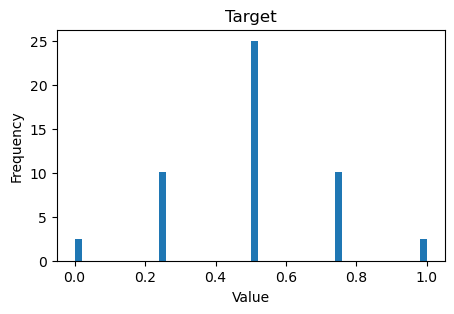

In [9]:
# Plot density histogram of the target
train["target"].plot(
  kind="hist",
  title="Target",
  figsize=(5, 3),
  xlabel="Value",
  density=True,
  bins=50
)

### Features
The `features` are quantitative attributes of each stock: fundamentals like P/E ratio, technical signals like RSI, market data like short interest, secondary data like analyst ratings, and much more.

The underlying definition of each feature is not important, just know that Numerai has included these features in the dataset because we believe they are predictive of the `target` either by themselves or in combination with other features.

Feature values are binned into 5 equal bins: `0`, `1`, `2`, `3`, `4`. This heavy regularization of feature values is to avoid overfitting as the underlying values are extremely noisy. Unlike the target, these are integers instead of floats to reduce the storage needs of the overall dataset.

If data for a particular feature is missing for that era (more common in early `eras`), then all values will be set to `2`.

<Axes: title={'center': 'missing data'}, ylabel='Frequency'>

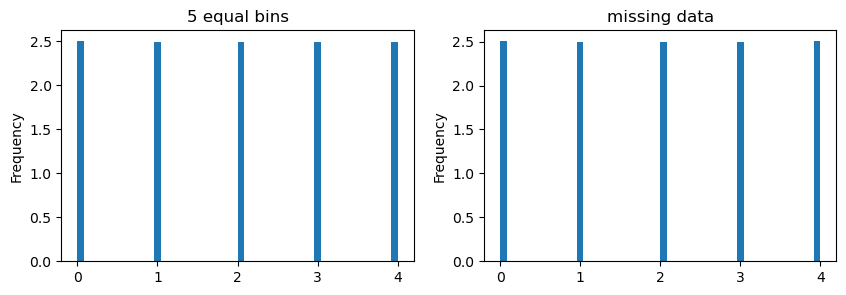

In [10]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
first_era = train[train["era"] == train["era"].unique()[0]]
last_era = train[train["era"] == train["era"].unique()[-1]]
last_era[feature_set[-1]].plot(
   title="5 equal bins",
   kind="hist",
   density=True,
   bins=50,
   ax=ax1
)
first_era[feature_set[-1]].plot(
   title="missing data",
   kind="hist",
   density=True,
   bins=50,
   ax=ax2
)

## 2. Modeling
At a high level, our task is to model and predict the `target` using the `features`.

### Model training

You are free to use any tool or framework, but here we will be using LGBMRegressor, a popular choice amongst tournament participants. While you wait for the model to train, watch this [video](https://www.youtube.com/watch?v=w8Y7hY05z7k) to learn why tree-based models work so well on tabular datasets from our Chief Scientist MDO.

In [11]:
# Download validation data - this will take a few minutes
napi.download_dataset(f"{DATA_VERSION}/validation_int8.parquet");

# Load the validation data and filter for data_type == "validation"
validation = pd.read_parquet(
    f"{DATA_VERSION}/validation_int8.parquet",
    columns=["era", "data_type", "target"] + feature_set
)
validation = validation[validation["data_type"] == "validation"]
del validation["data_type"]

# Downsample to every 4th era to reduce memory usage and speedup evaluation (suggested for Colab free tier)
# Comment out the line below to use all the data (slower and higher memory usage, but more accurate evaluation)
# validation = validation[validation["era"].isin(validation["era"].unique()[::4])]

# Eras are 1 week apart, but targets look 20 days (o 4 weeks/eras) into the future,
# so we need to "embargo" the first 4 eras following our last train era to avoid "data leakage"
last_train_era = int(train["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
validation = validation[~validation["era"].isin(eras_to_embargo)]

2024-03-15 22:30:02,411 INFO numerapi.utils: target file already exists
2024-03-15 22:30:02,413 INFO numerapi.utils: download complete


Training model 1/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 28187, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

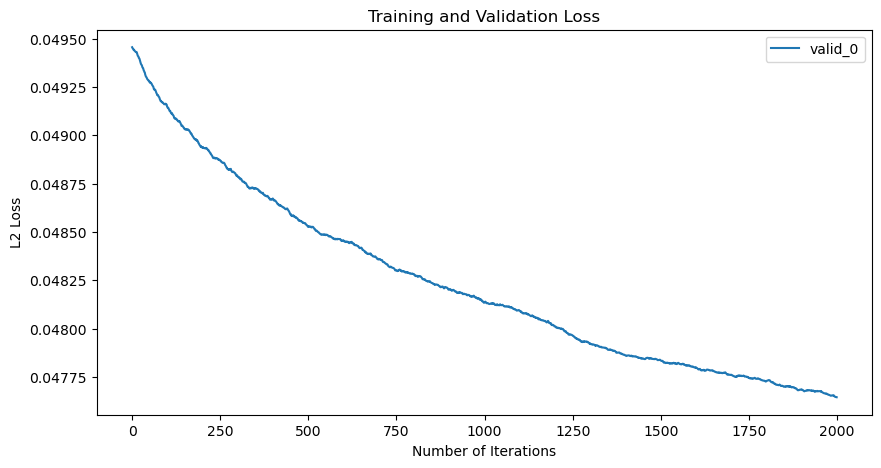

Training model 2/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 28542, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

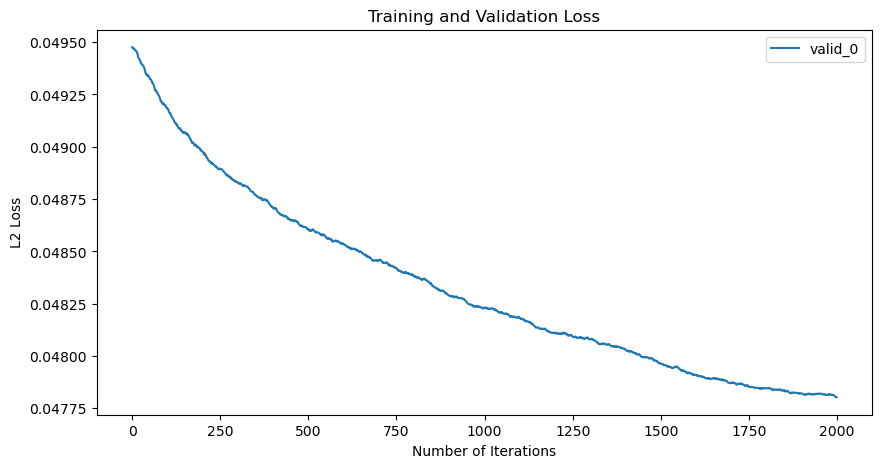

Training model 3/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 28713, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.499974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

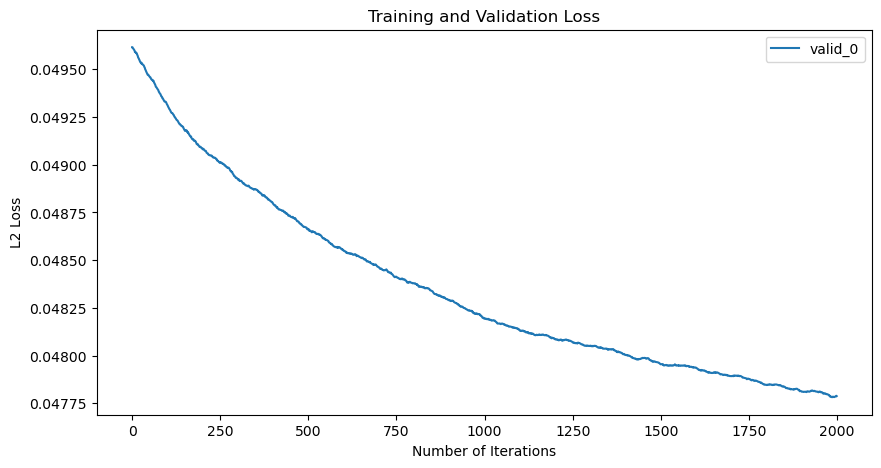

Training model 4/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 28824, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.499931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

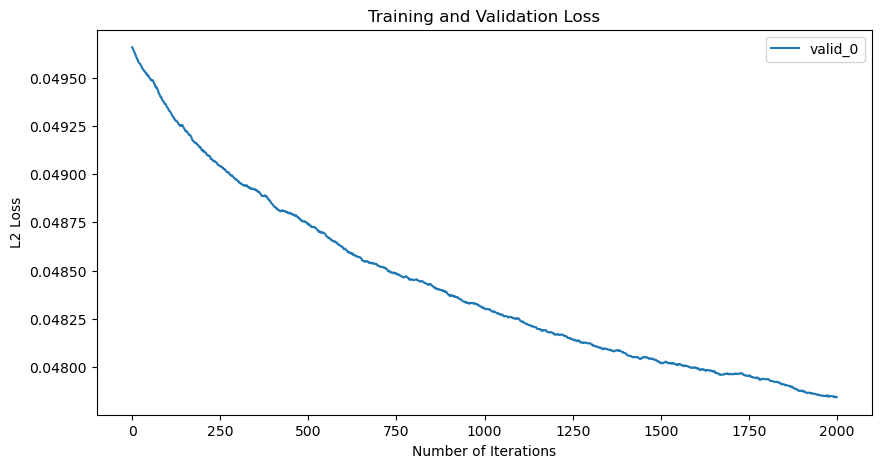

Training model 5/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 28867, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.499948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

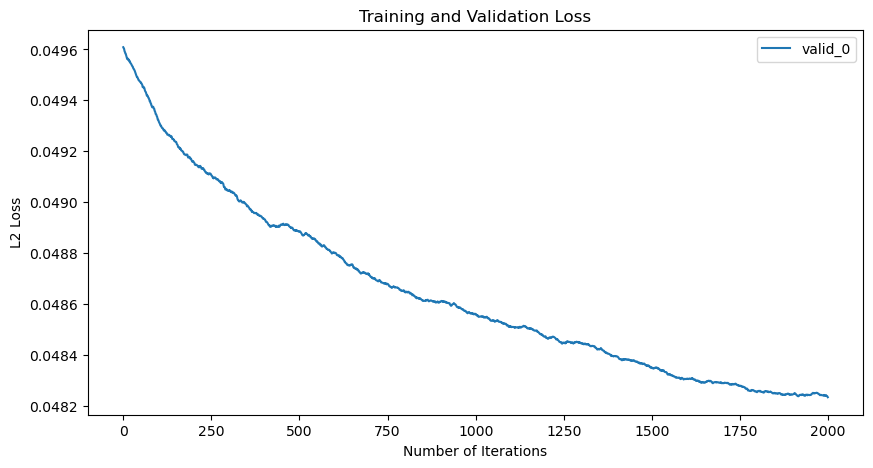

Training model 6/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 28988, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

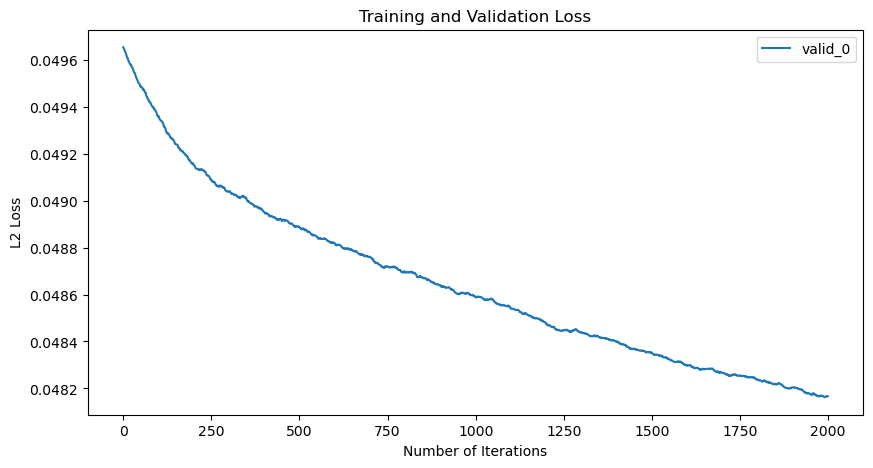

Training model 7/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 29127, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

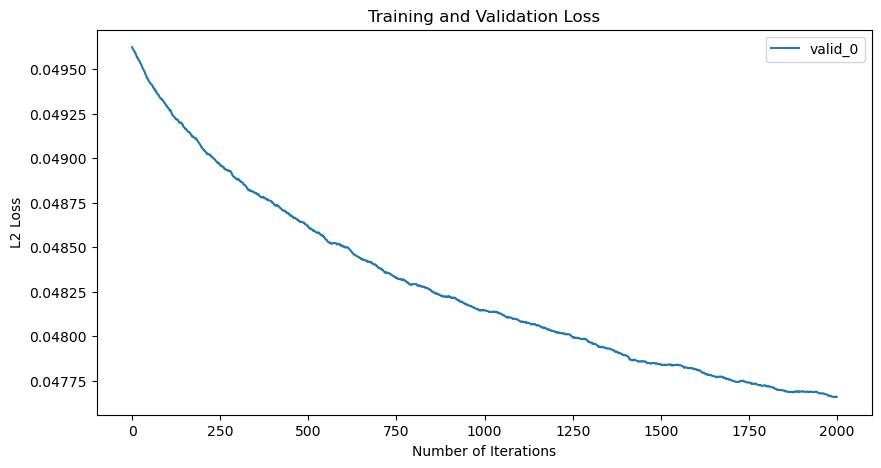

Training model 8/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 29287, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.499966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

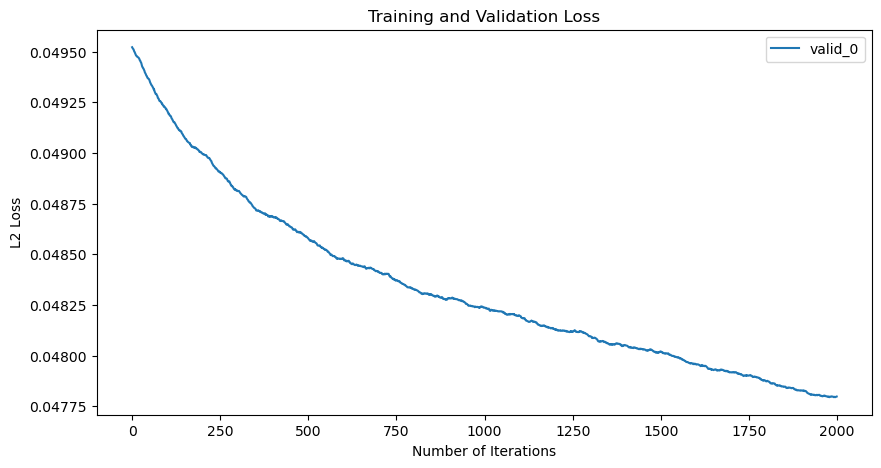

Training model 9/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 29511, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

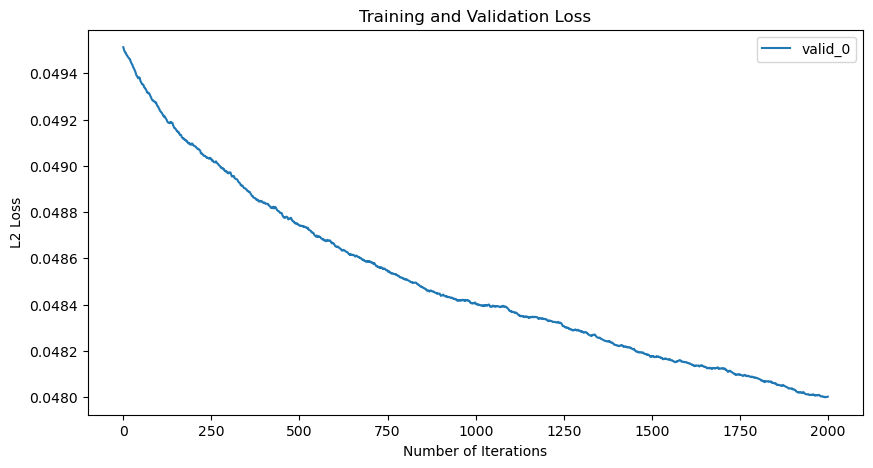

Training model 10/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 29793, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.499992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

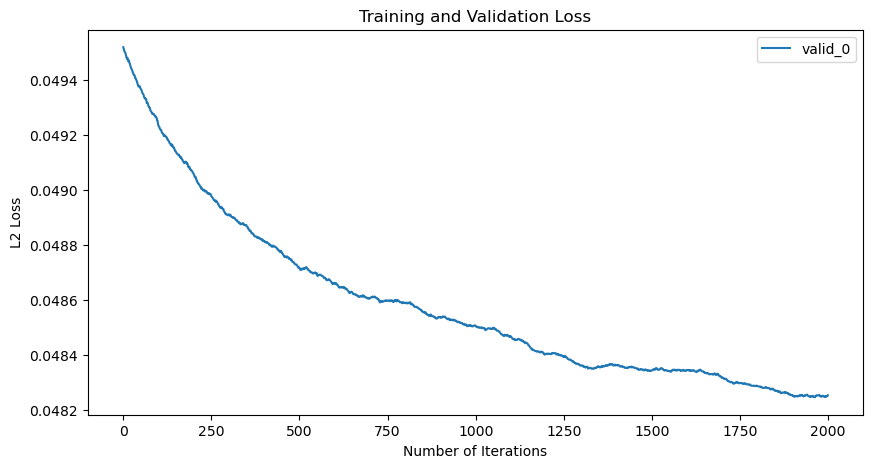

Training model 11/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 30105, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

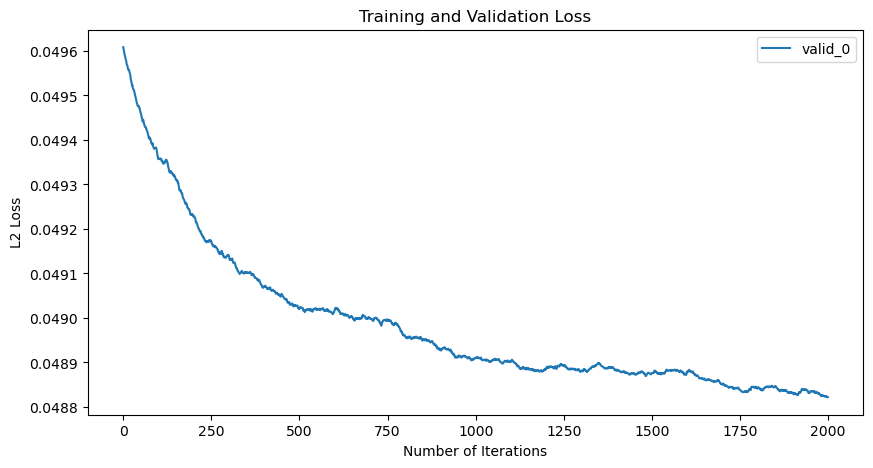

Training model 12/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 30474, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

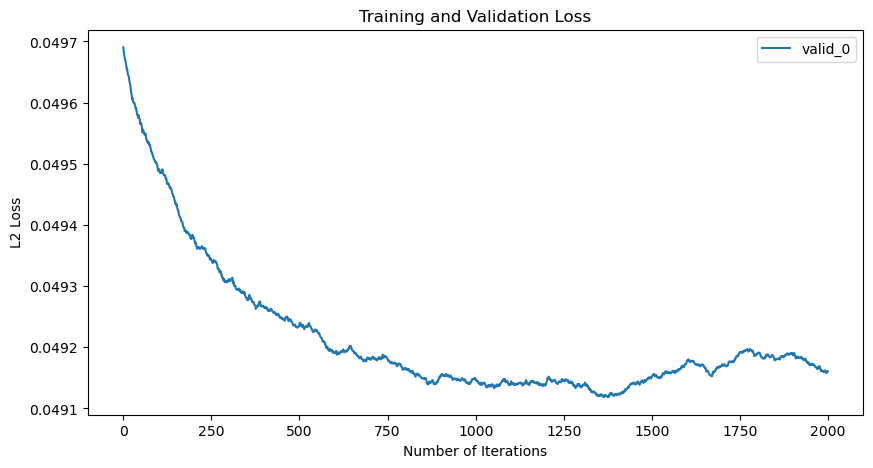

Training model 13/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 30776, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

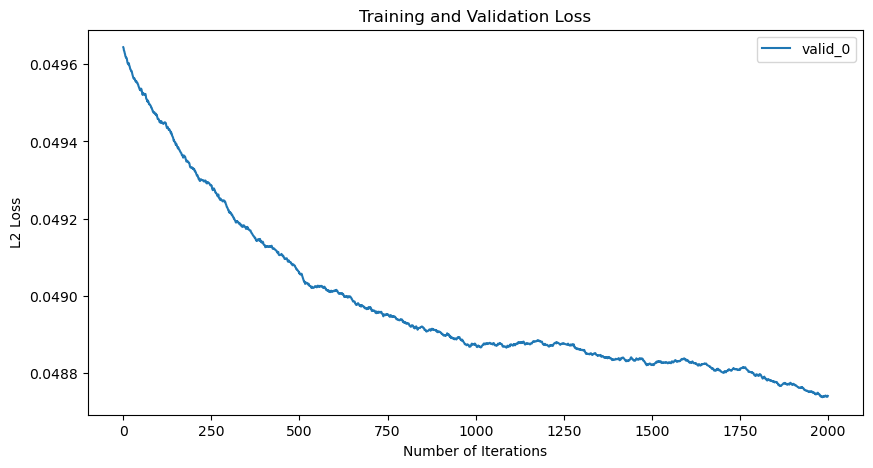

Training model 14/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 31193, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

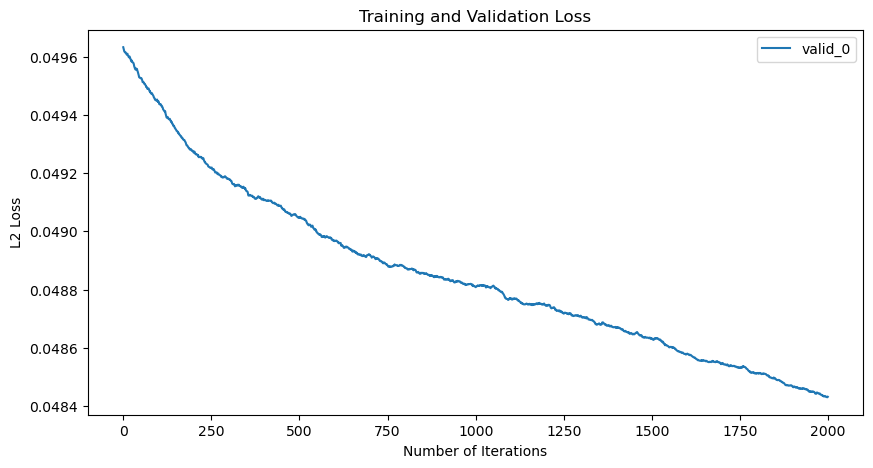

Training model 15/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 31607, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500040
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

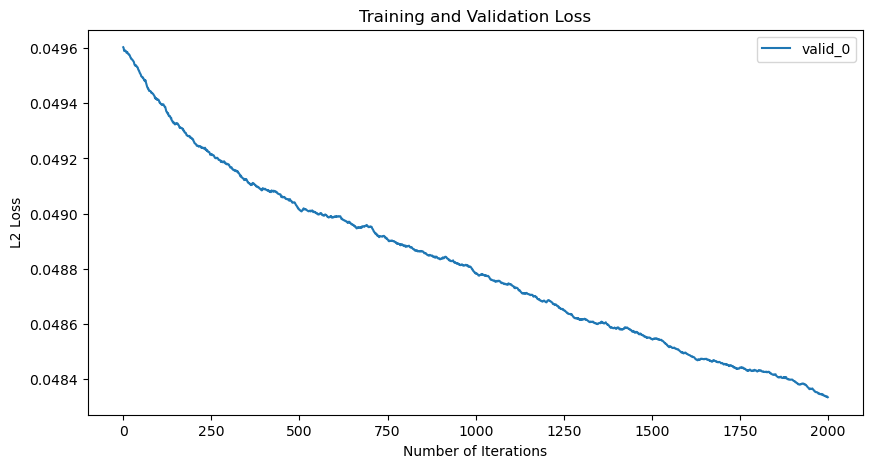

Training model 16/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 32062, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

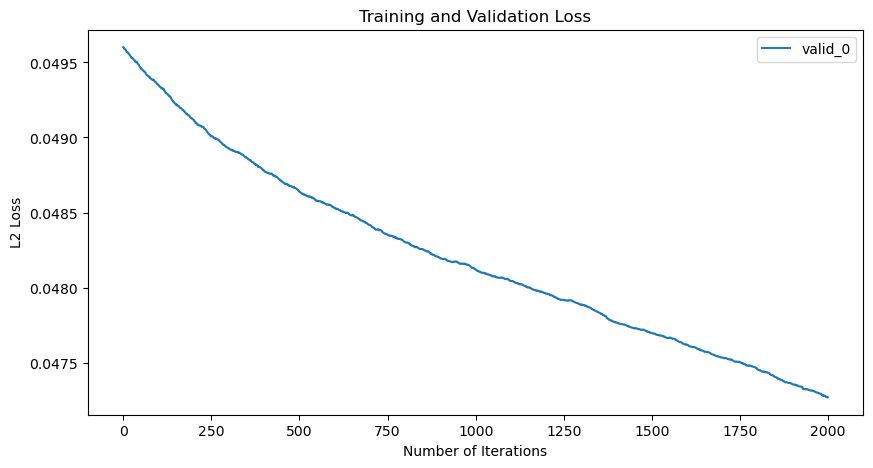

Training model 17/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 32535, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

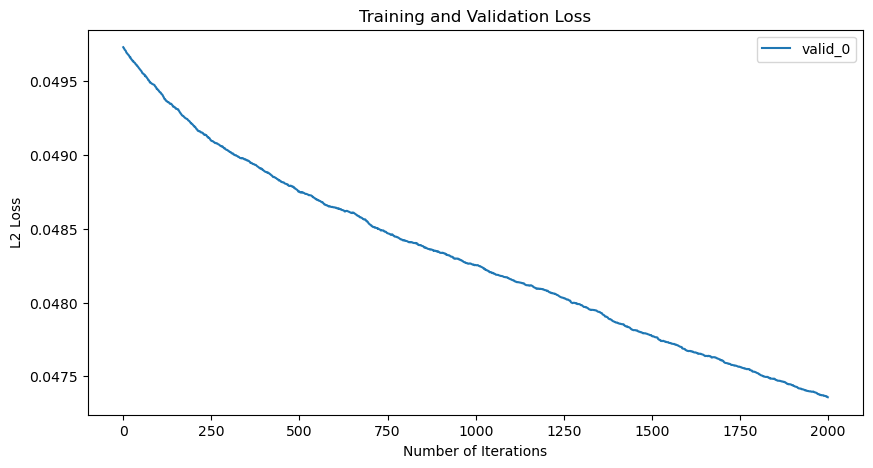

Training model 18/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 33001, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

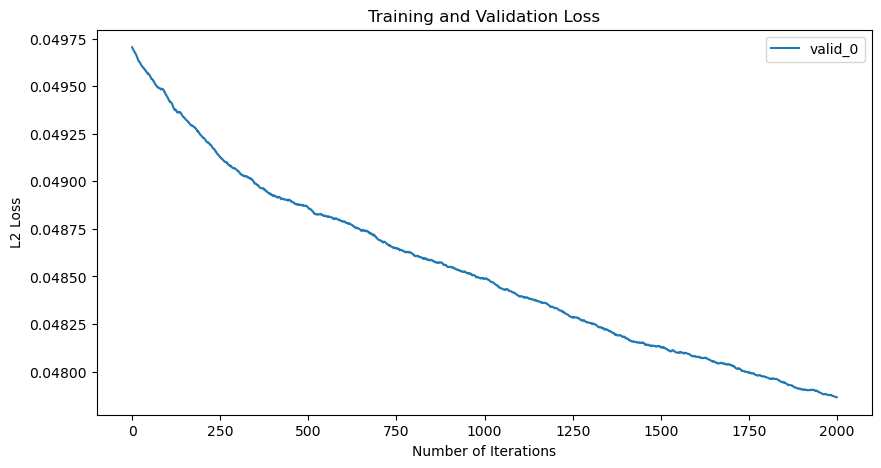

Training model 19/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 33451, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

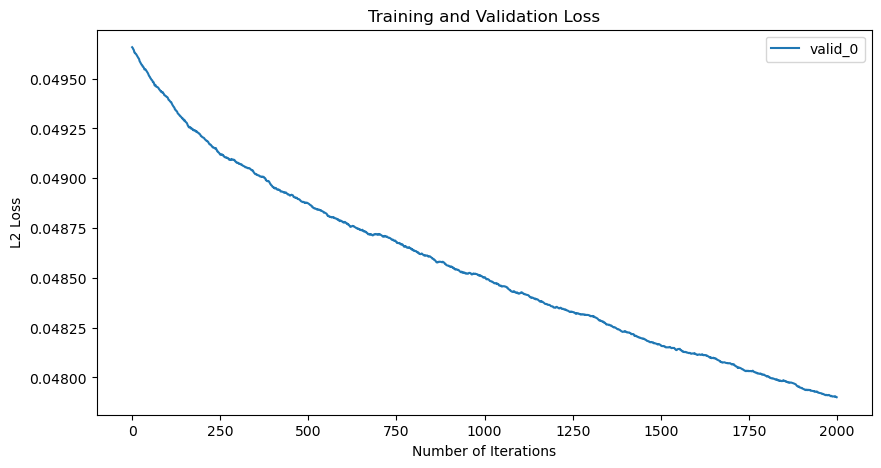

Training model 20/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 33886, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

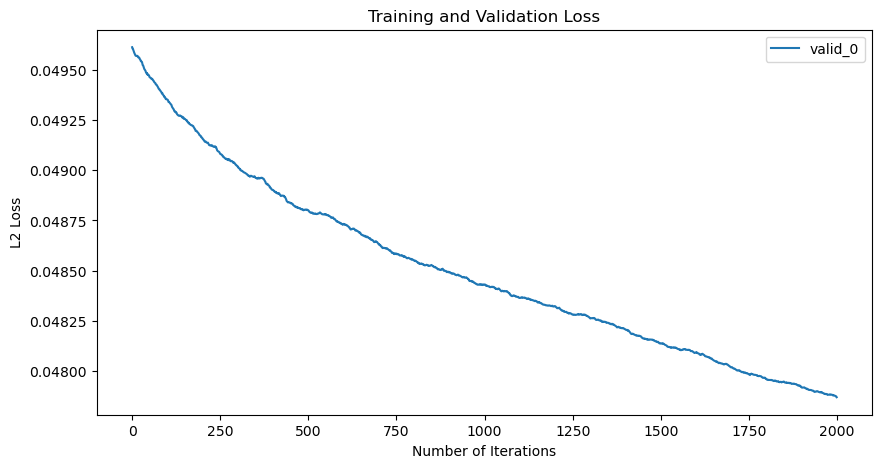

Training model 21/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 34296, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

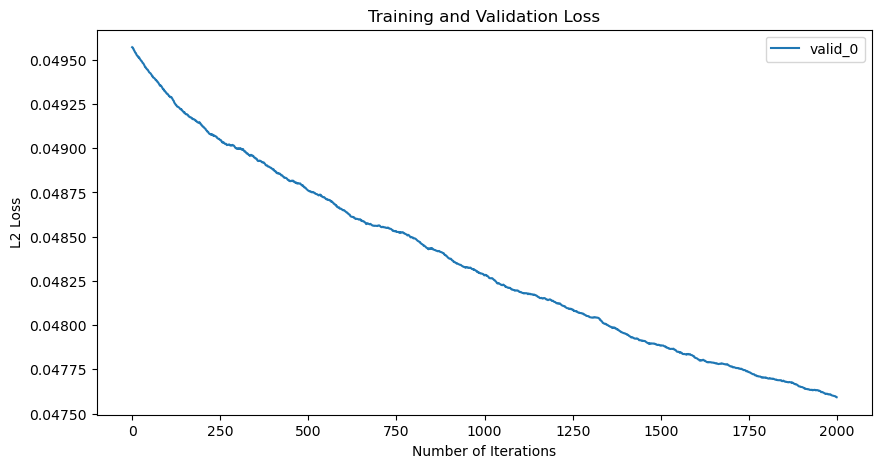

Training model 22/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 34663, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

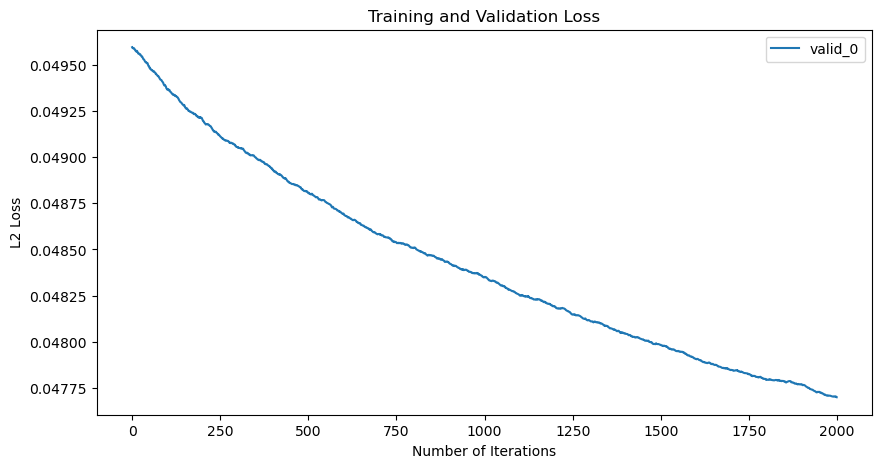

Training model 23/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 34980, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

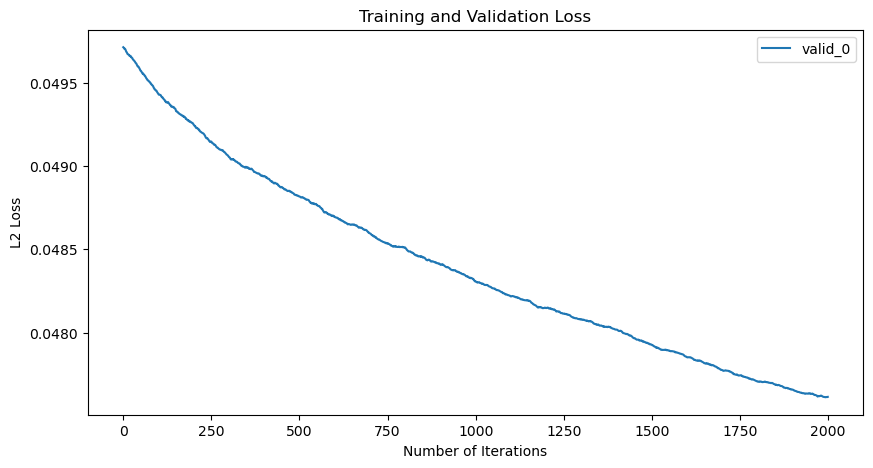

Training model 24/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 35282, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

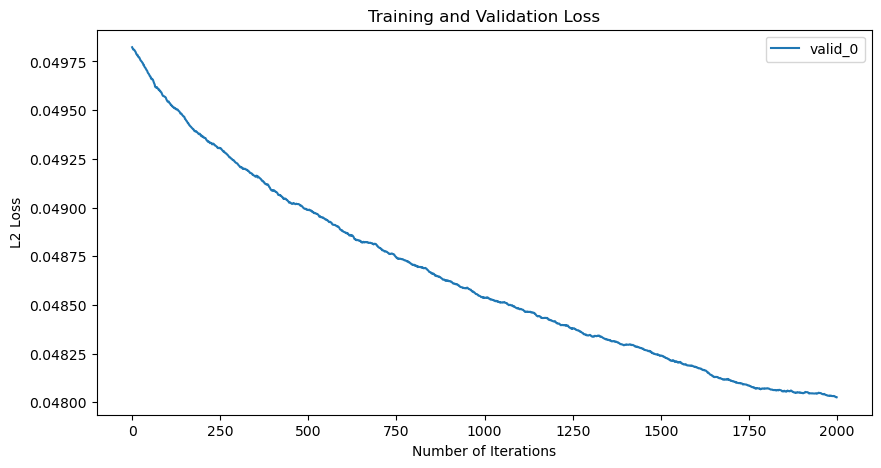

Training model 25/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 35588, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

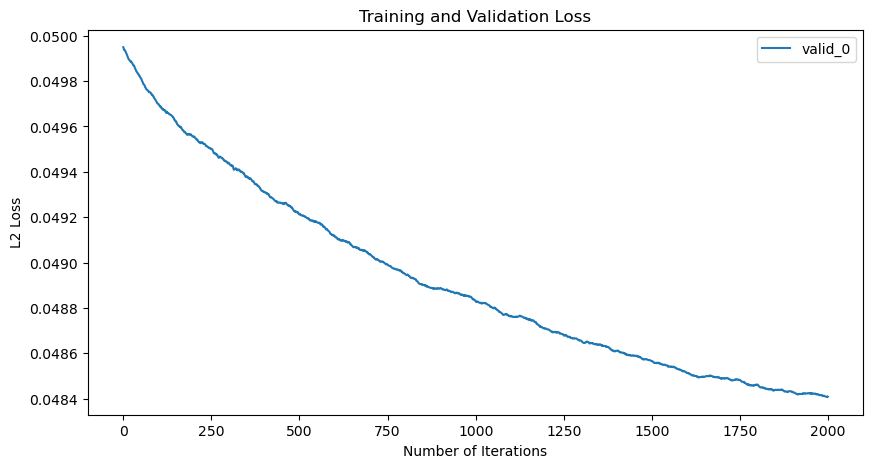

Training model 26/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 35780, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

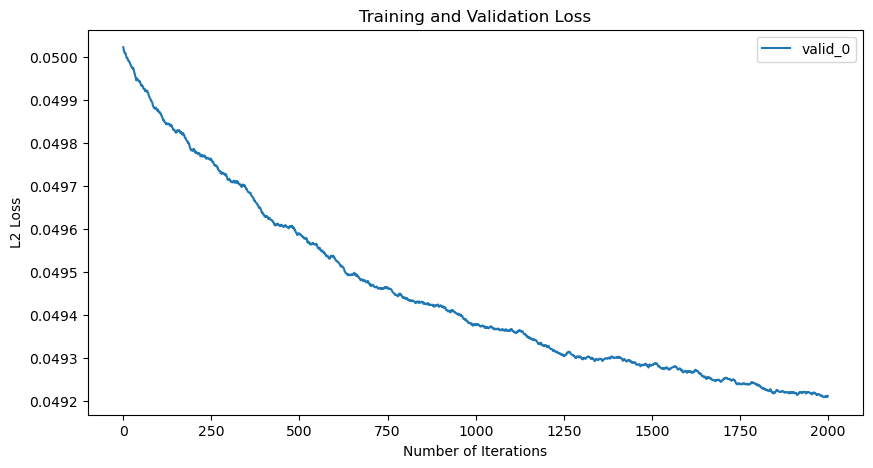

Training model 27/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 36078, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

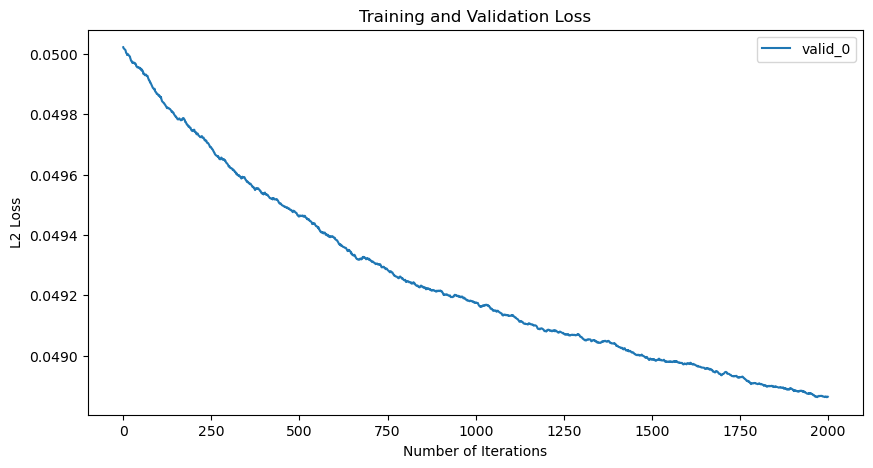

Training model 28/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 36343, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500220
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

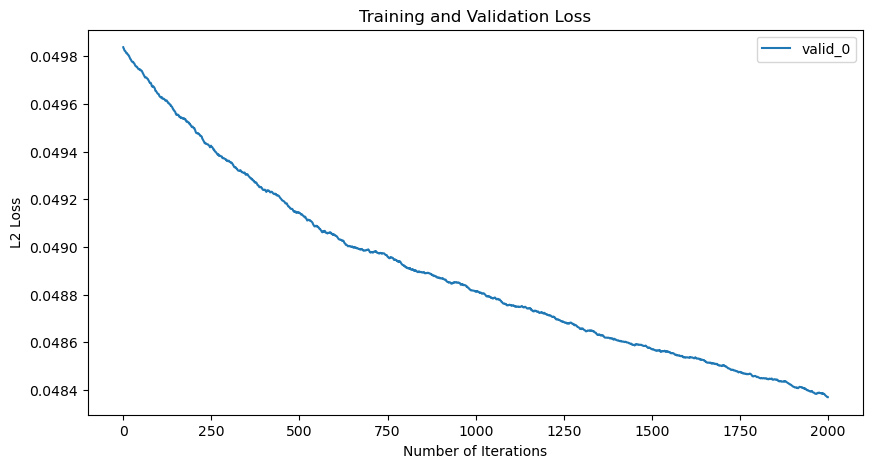

Training model 29/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 36618, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

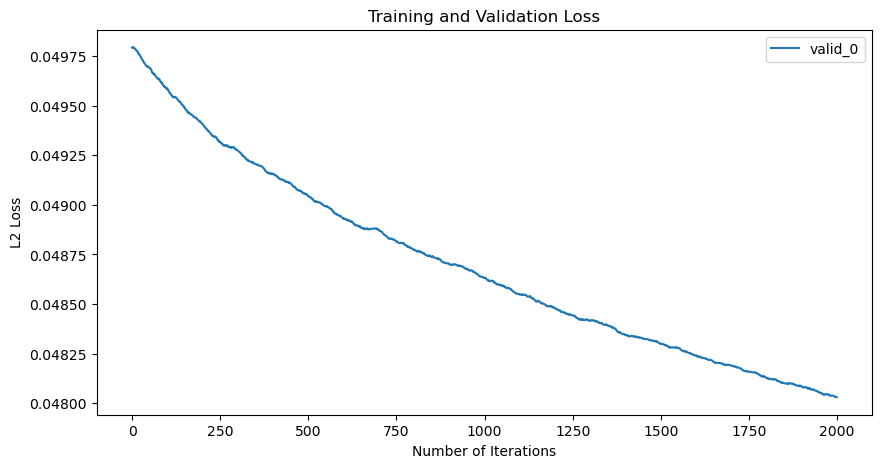

Training model 30/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 36821, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

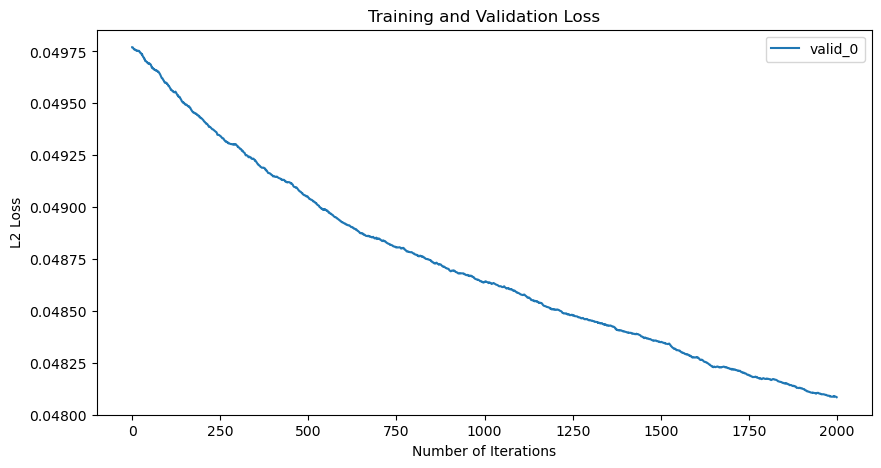

Training model 31/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 37004, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

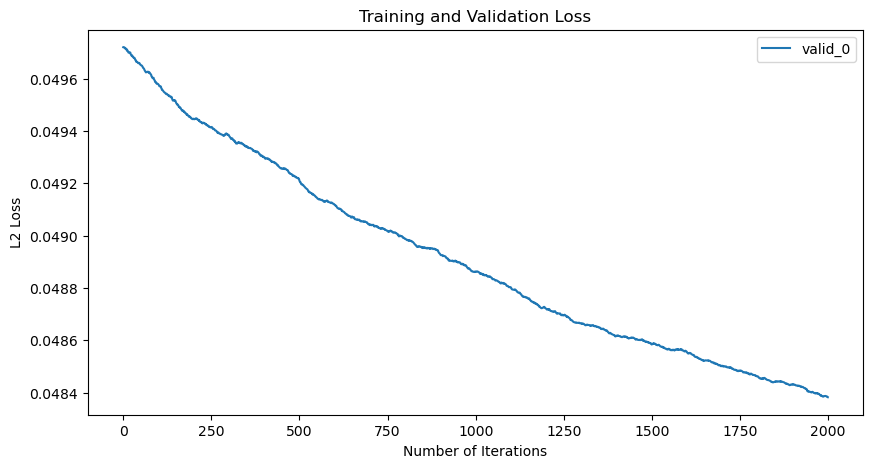

Training model 32/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 37301, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500248
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

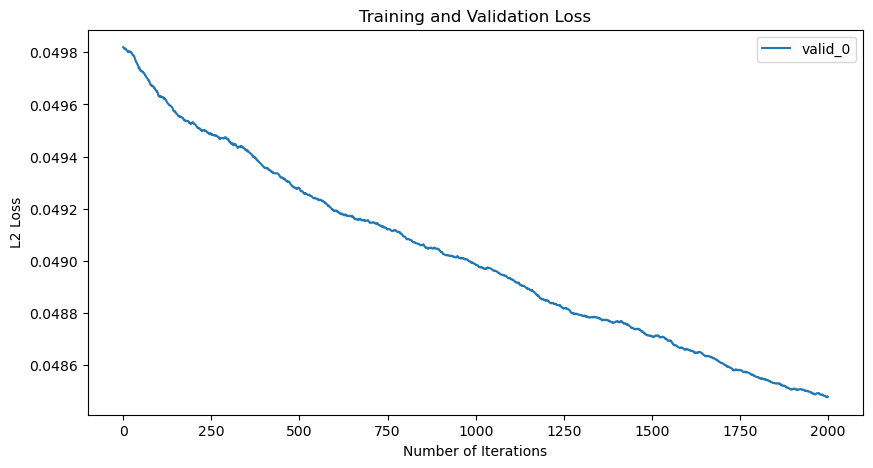

Training model 33/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 37618, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

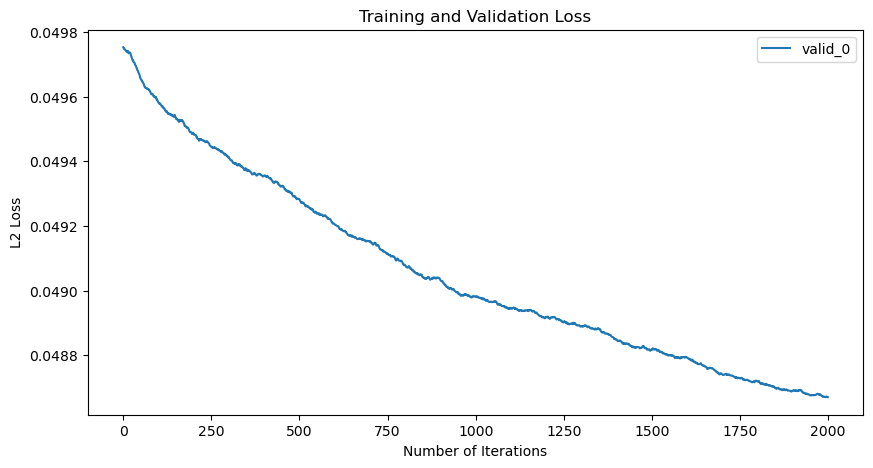

Training model 34/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 37958, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

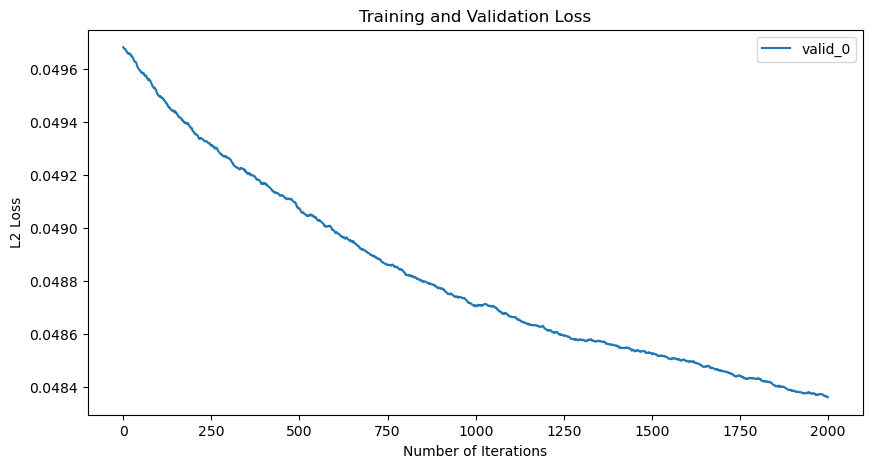

Training model 35/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 38327, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

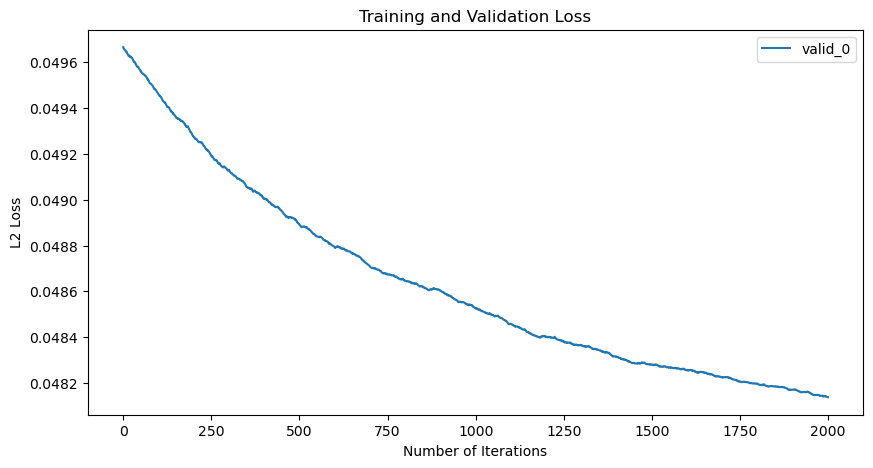

Training model 36/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 38676, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

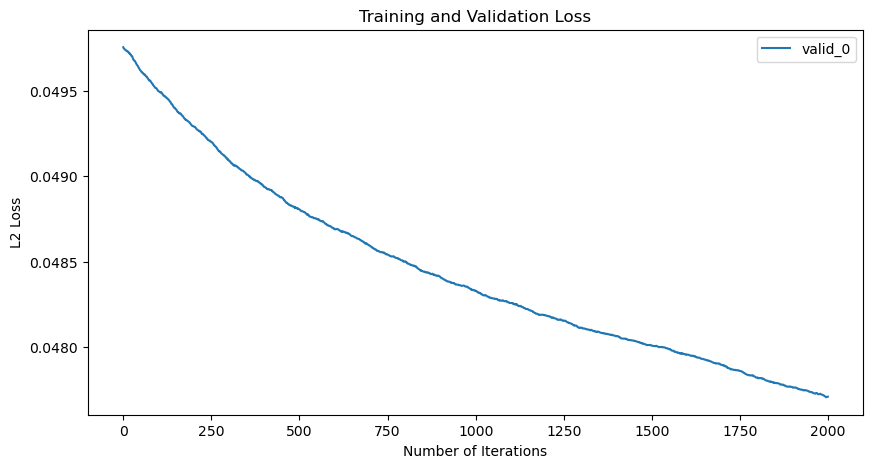

Training model 37/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 39036, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500090
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

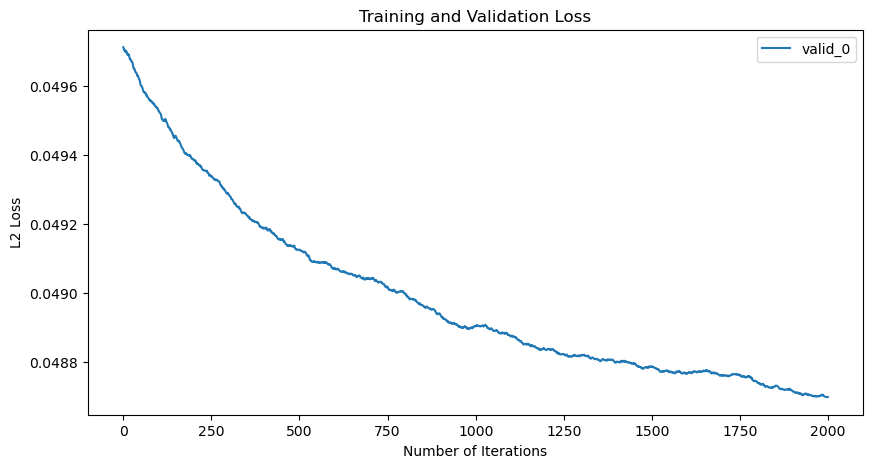

Training model 38/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 39397, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

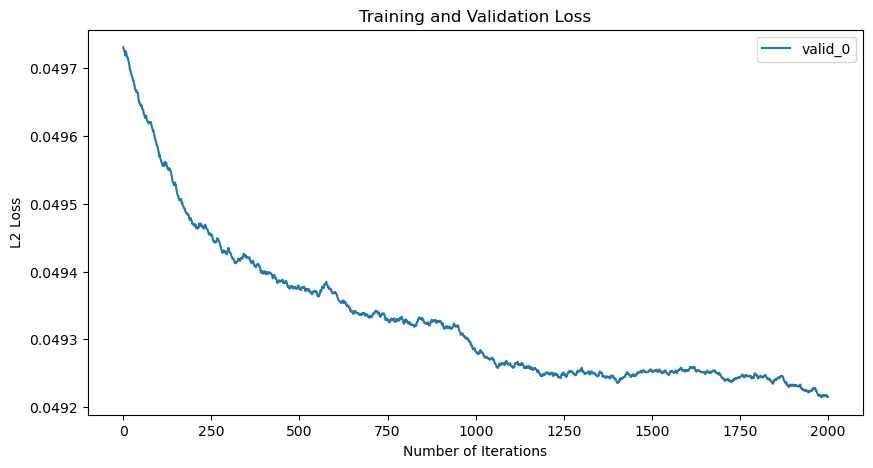

Training model 39/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 39659, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

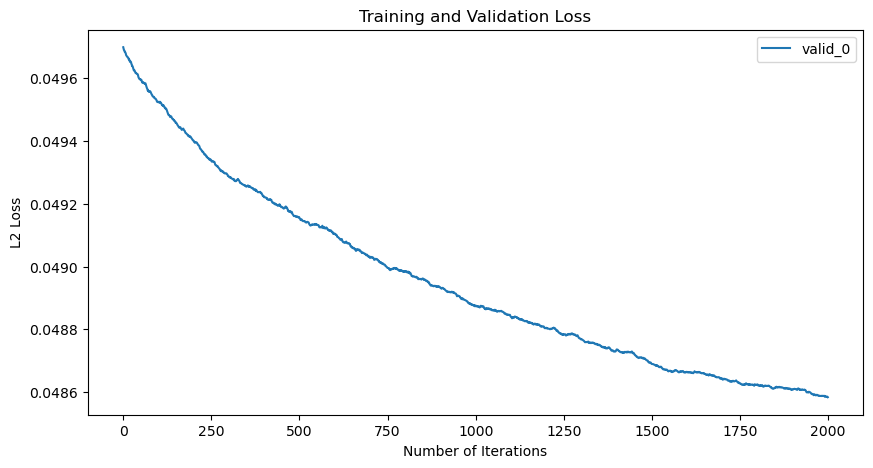

Training model 40/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 39908, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

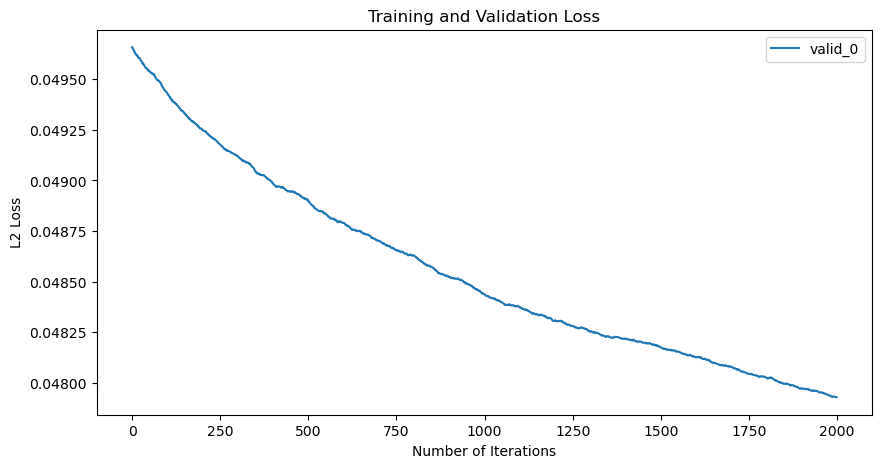

Training model 41/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 40128, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

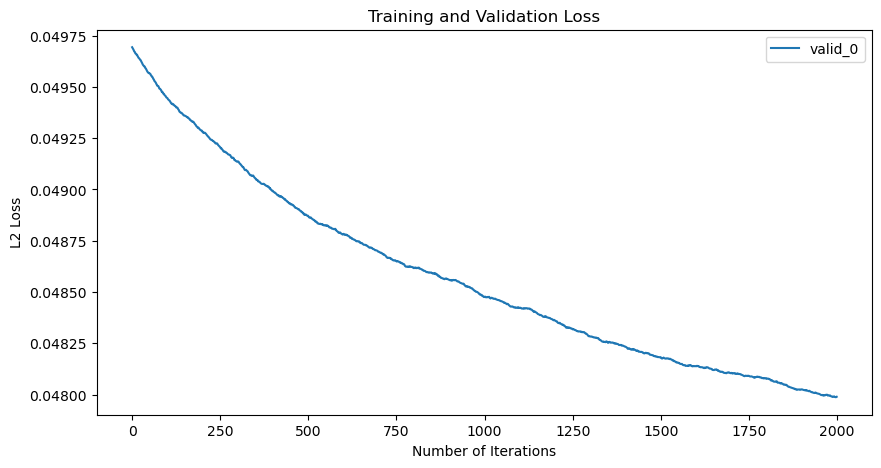

Training model 42/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 40353, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

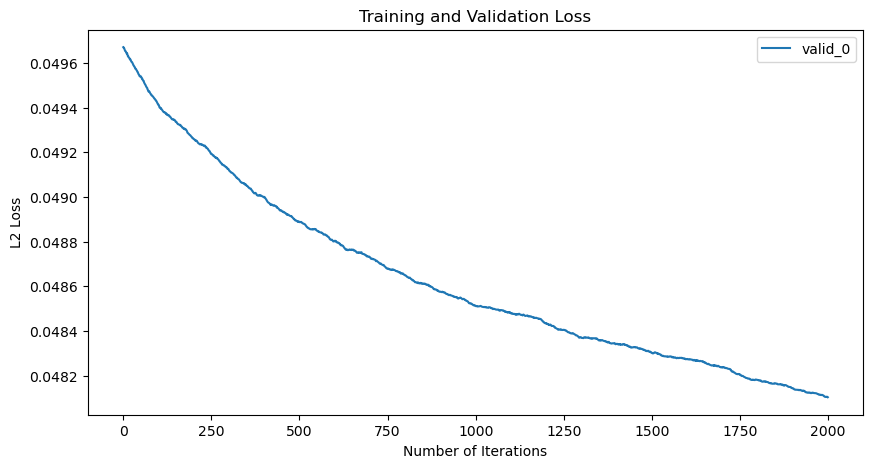

Training model 43/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 40588, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

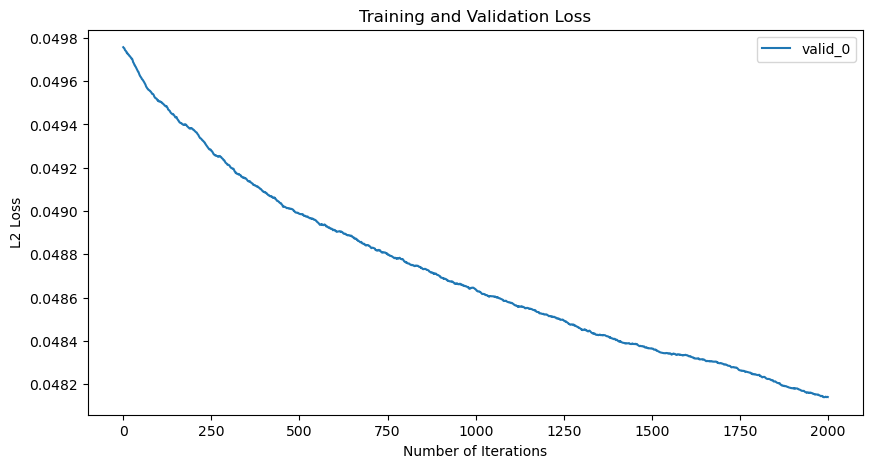

Training model 44/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 40691, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

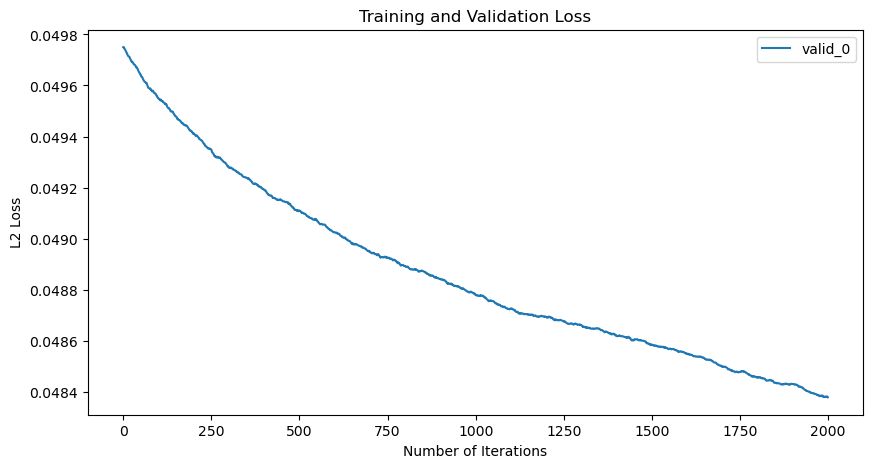

Training model 45/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 40816, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

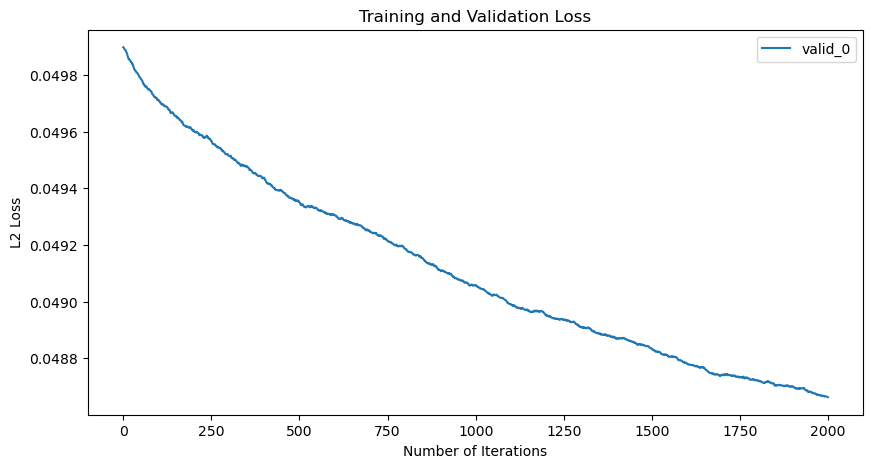

Training model 46/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 40745, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

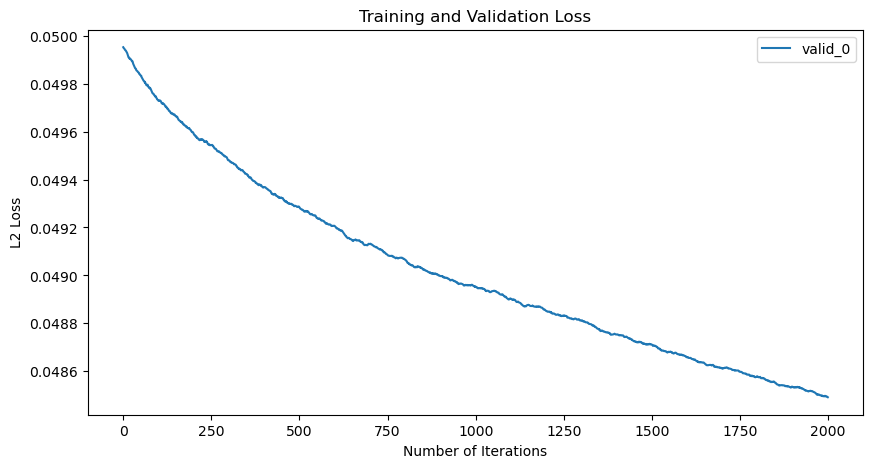

Training model 47/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 40824, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

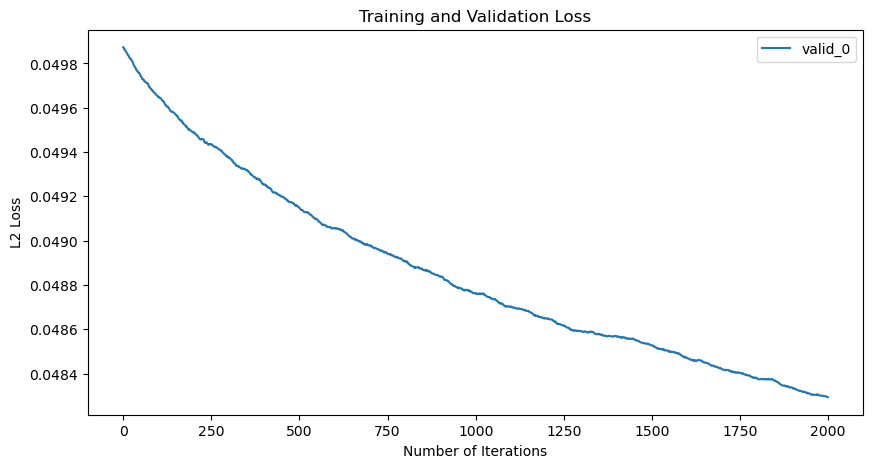

Training model 48/559
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 40917, number of used features: 545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.500031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

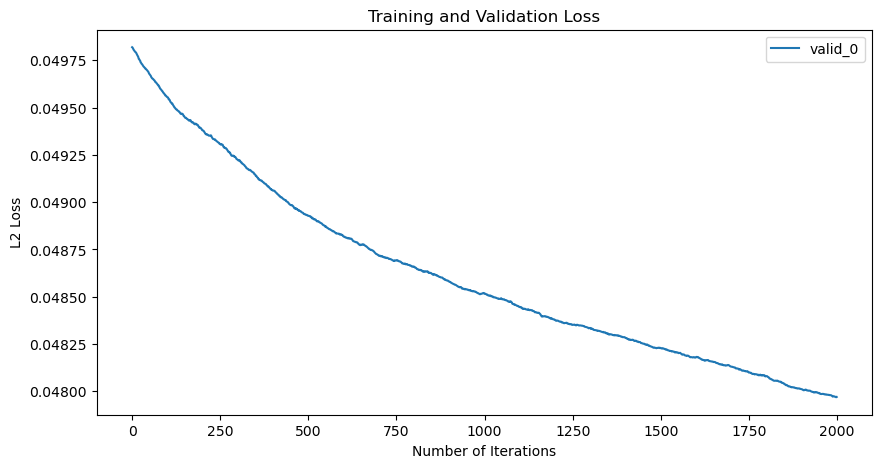

: 

In [17]:
import lightgbm as lgb
import matplotlib.pyplot as plt

model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    num_leaves=2**5-1,
    colsample_bytree=0.1
)

# Assuming 'train' is your full dataset and is sorted by era
eraindex = train['era'].unique()

# Lists to store training and validation loss
training_loss = []
validation_loss = []

early_stopping_callback = lgb.early_stopping(
  stopping_rounds=100,
  first_metric_only=True,
  verbose=True,
  min_delta=0.001  # Example value, adjust based on your needs
)

# Walk-forward validation
for i in range(len(eraindex) - (12 + 4) + 1):
    print(f"Training model {i+1}/{len(eraindex) - (12 + 4) + 1}")
  
    # Define training and validation sets
    train_set = train[train['era'].isin(eraindex[i:i+12])]
    valid_set = train[train['era'].isin(eraindex[i+12:i+12+4])]

    # Initialize a dictionary to store evaluation results for the current era
    evals_result = {}

    # Create callbacks for early stopping and recording evaluation
    record_eval_callback = lgb.record_evaluation(evals_result)
    

    # Train the model with callbacks for early stopping and recording evaluation
    model.fit(
        train_set[feature_set],
        train_set["target"],
        eval_set=[(train_set[feature_set], train_set["target"]),
                  (valid_set[feature_set], valid_set["target"])],
        eval_names=['train', 'valid'],
        callbacks=[record_eval_callback, early_stopping_callback],
        verbose=False
    )

    # Accumulate the mean of losses for each era
    training_loss.append(np.mean(evals_result['train']['l2']))
    validation_loss.append(np.mean(evals_result['valid']['l2']))

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss Across All Eras')
plt.xlabel('Era')
plt.ylabel('Mean L2 Loss')
plt.legend()
plt.show()


### Validation predictions

Now let's make some out-of-sample predictions on the validation dataset to evaluate our model's performance.

In [ ]:
# Generate predictions against the out-of-sample validation features
# This will take a few minutes 🍵
validation["prediction"] = model.predict(validation[feature_set])
validation[["era", "prediction", "target"]]

2024-03-15 22:11:47,796 INFO numerapi.utils: target file already exists
2024-03-15 22:11:47,798 INFO numerapi.utils: download complete


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,era,prediction,target
id,,,
n0005339ce5e6cad,0578,0.501015,0.50
n001e265c6584874,0578,0.503519,0.25
n0044ca3c1123a0f,0578,0.501893,0.75
n0046736de1c970b,0578,0.511551,1.00
n0057d0539b0d348,0578,0.500737,0.50
...,...,...,...
nffdbc589ff94086,1100,0.496008,0.50
nffe096923774db2,1100,0.502348,0.75
nffe0bdc96f343d3,1100,0.492547,0.75


### Performance evaluation

Numerai calculates scores designed to "align incentives" between your model and the hedge fund - a model with good scores should help the hedge fund make good returns. The primary scoring metrics in Numerai are:

- `CORR` (or "Correlation") which is calculated by the function `numerai_corr` - a Numerai specific variant of the Pearson Correlation between your model and the target.

- `MMC` (or "Meta Model Contribution") which is a calculated by the function `correlation_contribution` - a measure of how uniquely additive your model is to the Numerai Meta Model.

On the Numerai website you will see `CORR` referred to as `CORR20V2`, where the "20" refers to the 20-day return target and "v2" specifies that we are using the 2nd version of the scoring function.

In [ ]:
# install Numerai's open-source scoring tools
!pip install -q --no-deps numerai-tools

# import the 2 scoring functions
from numerai_tools.scoring import numerai_corr, correlation_contribution

# Download and join in the meta_model for the validation eras
napi.download_dataset(f"{DATA_VERSION}/meta_model.parquet")
validation["meta_model"] = pd.read_parquet(
    f"{DATA_VERSION}/meta_model.parquet"
)["numerai_meta_model"]

2024-03-15 22:12:12,309 INFO numerapi.utils: target file already exists
2024-03-15 22:12:12,310 INFO numerapi.utils: download complete


As mentioned above, it is important for us to score each historical `era` independantly. So when evaluating the performance of our model, we should be looking at the "per era" metrics.

One thing you may notice here is how low the scores are (in the range of +/- 0.05). This is very normal in the domain of quantitative finance and is part of the reason why we say Numerai is the "hardest data science tournament" in the world.

<Axes: title={'center': 'Validation MMC'}, xlabel='era'>

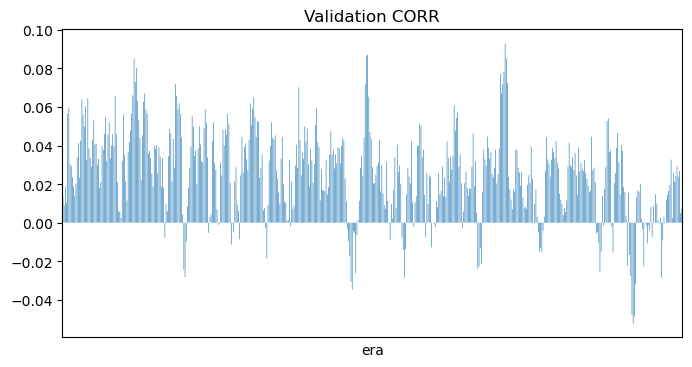

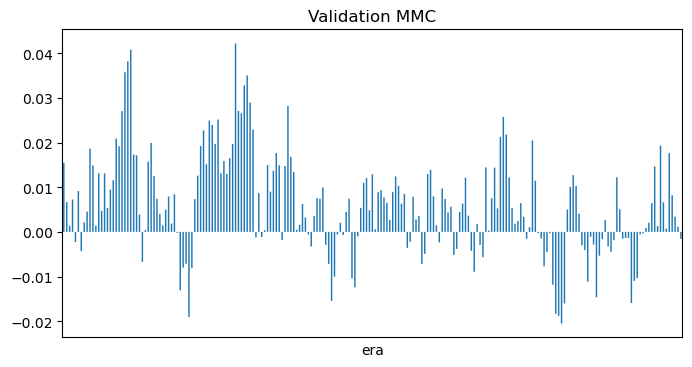

In [ ]:
# Compute the per-era corr between our predictions and the target values
per_era_corr = validation.groupby("era").apply(
    lambda x: numerai_corr(x[["prediction"]].dropna(), x["target"].dropna())
)

# Compute the per-era mmc between our predictions, the meta model, and the target values
per_era_mmc = validation.dropna().groupby("era").apply(
    lambda x: correlation_contribution(x[["prediction"]], x["meta_model"], x["target"])
)


# Plot the per-era correlation
per_era_corr.plot(
  title="Validation CORR",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)
per_era_mmc.plot(
  title="Validation MMC",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)

Instead of looking at the raw score for each era, it is helpful to look at the cumulative scores.

If you are familiar with "backtesting" in quant finance where people simulate the historical performance of their investment strategies, you can roughly think of this plot as a backtest of your model performance over the historical validation period.

Notice a few things below:

- CORR gradually increases over many eras of the validation data even with this simple model on modern data.

- MMC is generated over a smaller set of recent eras - this is because the validation time range pre-dates the Meta Model.

- MMC is very high early on in the Meta Model's existence, MMC - this is because the newest datasets were not available and models trained on the newest data are could have been very additive in the past.

- MMC is flat and decreasing recently because the Meta Model has started catching up to modern data sets and getting correlation has been difficult in recent eras.

<Axes: title={'center': 'Cumulative Validation MMC'}, xlabel='era'>

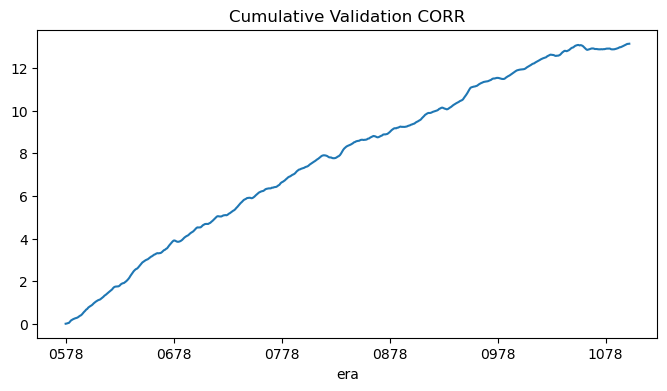

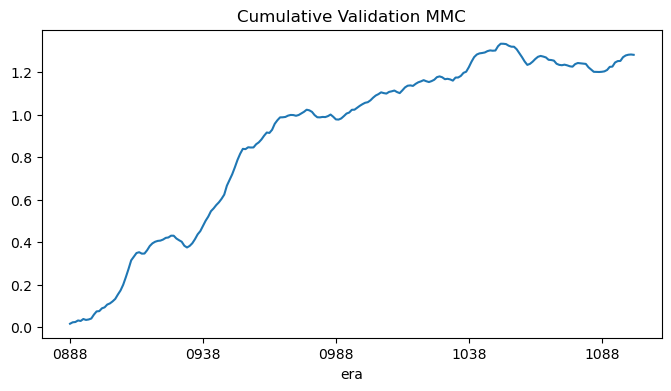

In [ ]:
# Plot the cumulative per-era correlation
per_era_corr.cumsum().plot(
  title="Cumulative Validation CORR",
  kind="line",
  figsize=(8, 4),
  legend=False
)
per_era_mmc.cumsum().plot(
  title="Cumulative Validation MMC",
  kind="line",
  figsize=(8, 4),
  legend=False
)

### Performance metrics

To evaluate the performance of our model, it is also helpful to compute some summary metrics over the entire validation period:

- `Mean` is the primary measure of your model's long-term performance.

- `Sharpe` is a measure of your model's consistency. In finance, the Sharpe ratio of an investment strategy measures risk adjusted returns. In Numerai, we compute sharpe as the mean divided by the standard deviation.

- `Max drawdown` is a measure of your model's risk. In finance, the max drawdown of an investment strategy is the largest loss suffered. In Numerai, we compute max drawdown as the maximum peak to trough drop in a cumulative score.

In [ ]:
# Compute performance metrics
corr_mean = per_era_corr.mean()
corr_std = per_era_corr.std(ddof=0)
corr_sharpe = corr_mean / corr_std
corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

mmc_mean = per_era_mmc.mean()
mmc_std = per_era_mmc.std(ddof=0)
mmc_sharpe = mmc_mean / mmc_std
mmc_max_drawdown = (per_era_mmc.cumsum().expanding(min_periods=1).max() - per_era_mmc.cumsum()).max()

pd.DataFrame({
    "mean": [corr_mean, mmc_mean],
    "std": [corr_std, mmc_std],
    "sharpe": [corr_sharpe, mmc_sharpe],
    "max_drawdown": [corr_max_drawdown, mmc_max_drawdown]
}, index=["CORR", "MMC"]).T

,CORR,MMC
mean,prediction 0.025122 dtype: float64,prediction 0.006016 dtype: float64
std,prediction 0.022714 dtype: float64,prediction 0.011265 dtype: float64
sharpe,prediction 1.106023 dtype: float64,prediction 0.534016 dtype: float64
max_drawdown,prediction 0.23137 dtype: float64,prediction 0.133078 dtype: float64


These performance metrics above are not amazing but that's ok, we are just getting started. In the next few tutorials, you will learn how to improve our model performance.

## 3. Submissions

Unlike Kaggle competitions that evalute models based on <ins>test</ins> performance, Numerai evaluates models based based on <ins>live</ins> performance.

### Live predictions

Every Tuesday-Saturday, new `live features` are released, which represent the current state of the stock market.

Your task is to generate `live predictions` on the unknown target values, which represent stock market returns 20 days into the future.

In [ ]:
# Download latest live features
napi.download_dataset(f"{DATA_VERSION}/live_int8.parquet")

# Load live features
live_features = pd.read_parquet(f"{DATA_VERSION}/live_int8.parquet", columns=feature_set)

# Generate live predictions
live_predictions = model.predict(live_features[feature_set])

# Format submission
pd.Series(live_predictions, index=live_features.index).to_frame("prediction")

2024-03-15 22:12:27,681 INFO numerapi.utils: starting download
v4.3/live_int8.parquet: 6.62MB [00:01, 4.05MB/s]                            


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,prediction
id,
n000104d37d8c734,0.483379
n0011898b7e93487,0.502915
n003ca954198e585,0.511351
n005691eeaead91b,0.497611
n0062bc69f34051b,0.490375
...,...
nffbf1eef86dcadf,0.480337
nffde6aa60fe866c,0.492981
nffe20cefa36adb6,0.509931


### Model upload

To participate in the tournament, you must submit live predictions every Tuesday-Saturday.

To automate this process, you can simply:
- Define your prediction pipeline as a function
- Serialize your function using the `cloudpickle` library
- Upload your model pickle file to Numerai
- Let Numerai run your model to submit live predictions every day

Read more about Model Uploads and other self-hosted automation options in our [docs](https://docs.numer.ai/numerai-tournament/submissions#automation).


In [ ]:
# Define your prediction pipeline as a function
def predict(live_features: pd.DataFrame) -> pd.DataFrame:
    live_predictions = model.predict(live_features[feature_set])
    submission = pd.Series(live_predictions, index=live_features.index)
    return submission.to_frame("prediction")

In [ ]:
# Use the cloudpickle library to serialize your function
import cloudpickle
p = cloudpickle.dumps(predict)
with open("predict.pkl", "wb") as f:
    f.write(p)

In [ ]:
# Download file if running in Google Colab
try:
    from google.colab import files
    files.download('predict.pkl')
except:
    pass

That's it! You now have a pickle file that is ready for upload.

Head back to the [Hello Numerai Tutorial](https://numer.ai/tutorial/hello-numerai) to upload your model!